### 🤖 LLM and AI Agent Development Courses  
**✨ All courses available for just ₹399 INR / $9.99 USD ✨**

| Course | Description | Enroll |
|--------|-------------|---------|
| **🎯 Master OpenAI Agent Builder** | Build and deploy AI agents visually using OpenAI Agent Builder, ChatKit, RAG, Chatbot, AI Assistant with MCP, AWS, RDS MySQL | [Enroll Now](https://kgptalkie.com/agent-builder) |
| **🔥 MCP Mastery** | Build MCP servers & clients with Python, Streamlit, ChromaDB, LangChain, LangGraph agents, and Ollama integrations | [Enroll Now](https://kgptalkie.com/mcp) |
| **📊 Private Agentic RAG with LangChain** | Step-by-Step Guide to RAG with LangChain v1, LangGraph, and Ollama (Qwen3, Gemma3, DeepSeek-R1, LLAMA, FAISS) | [Enroll Now](https://kgptalkie.com/agentic-rag) |
| **🔧 Master LangGraph and LangChain** | Agentic RAG and Chatbot, AI Agent with LangChain v1, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, FAISS Vector Database | [Enroll Now](https://kgptalkie.com/langgraph) |
| **⚡ Master Langchain and Ollama** | Master Langchain v1, Local LLM Projects with Ollama, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, Complete Integration Guide | [Enroll Now](https://kgptalkie.com/langchain) |
| **🔬 Fine Tuning LLM** | Learn transformer architecture fundamentals and fine-tune LLMs with custom datasets | [Enroll Now](https://kgptalkie.com/fine-tuning-llm) |

---

### 🌐 Join the Community & Stay Connected

- 🔗 **Join the Discord Community:** https://discord.gg/RFjwbkNa  
- 📺 **Subscribe on YouTube (63K+ learners):** http://www.youtube.com/@KGPTalkie

---


## LLM Integration & Routing with Structured Output

### Twitter - Social Media Customer Support Agent 

Learning Objectives:
- Integrate LLMs into LangGraph workflows
- Use Pydantic BaseModel for structured outputs with with_structured_output()
- Implement conditional routing based on sentiment

#### Real-World Applications:

1. Customer Service: Route tickets by urgency/sentiment with appropriate responses
2. Content Moderation: Binary classification (approved/flagged) with confidence
3. Email Response: Generate tone-appropriate replies based on sentiment strength
4. Review Analysis: Classify and respond to product reviews with matching intensity
5. Social Media Management: Brand-appropriate responses scaled to sentiment

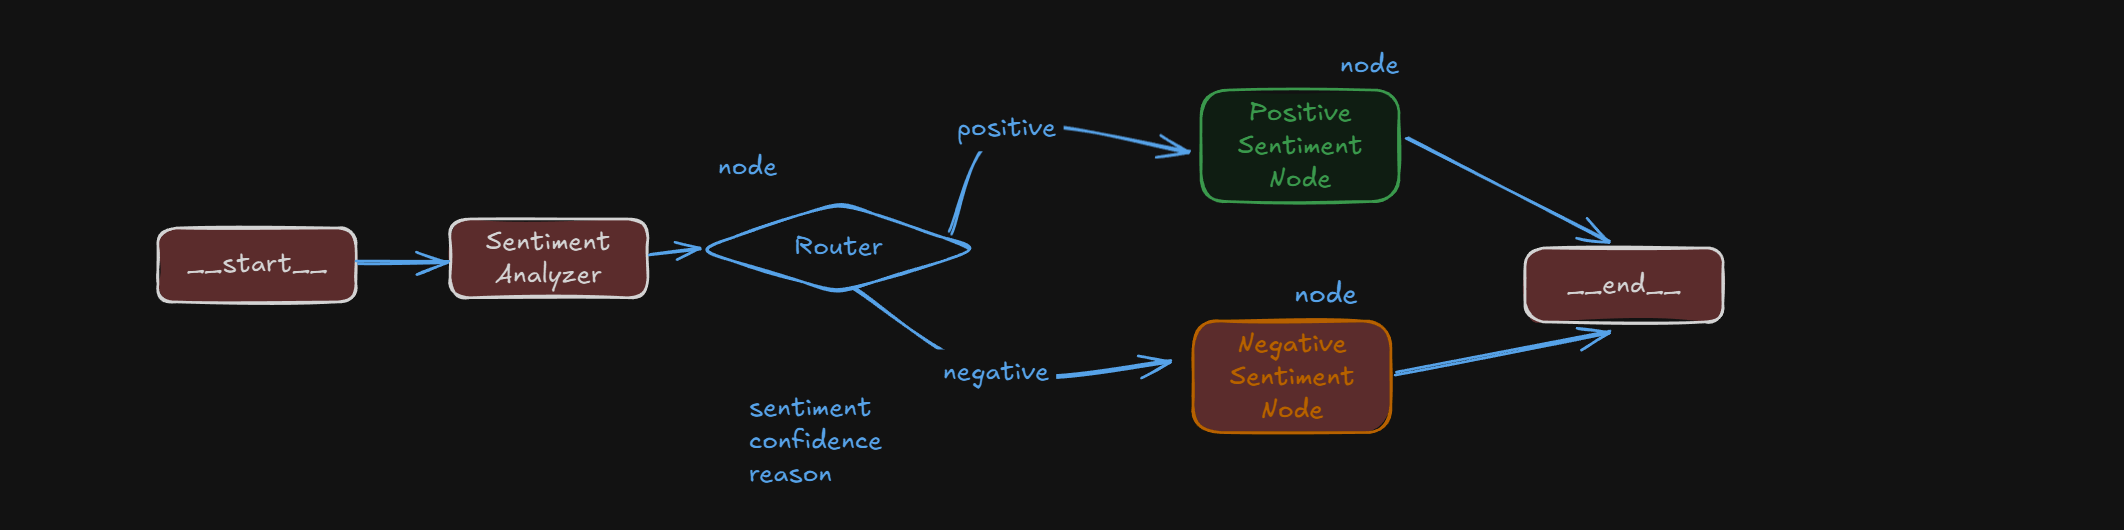

In [ ]:
# ollama pull deepseek-r1

In [3]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field


# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "deepseek-r1"  # Ensure this model is pulled in Ollama

llm = ChatOllama(model= MODEL_NAME, base_url=BASE_URL)


In [6]:
class SentimentAnalysis(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment classification either positive or negative")
    confidence: float = Field(ge=0, le=1.0, description="Confidence score from 0.0 to 1.0")
    reason: str = Field(description="Brief explanation")

In [2]:
# =============================================================================
# State Definition
# =============================================================================
class SentimentState(TypedDict):
    original_tweet: str
    sentiment: str
    confidence: float

    response_tweet: str

In [4]:
# =============================================================================
# Nodes
# =============================================================================
def analyze_sentiment(state: SentimentState):
    tweet = state['original_tweet']
    print(f"analyzing customer tweet: {tweet}")

    structured_llm = llm.with_structured_output(SentimentAnalysis)

    # ALT +Z
    messages = [
        SystemMessage("Analyze sentiment and provide the structured output. Use 0 to 1.0 scale for confidence. lower is negative and higher is positive"),
        HumanMessage(tweet)
    ]

    analysis = structured_llm.invoke(messages)

    print(f"Sentiment Analysis is done:\n{analysis}")

    return {'sentiment': analysis.sentiment,
            'confidence': analysis.confidence}



In [7]:
state = {'original_tweet': "Just launched my new product!"}
analyze_sentiment(state)

analyzing customer tweet: Just launched my new product!
Sentiment Analysis is done:
sentiment='positive' confidence=0.9 reason='The message expresses excitement about launching a new product, indicating a positive sentiment with high confidence due to the enthusiastic tone and lack of negative indicators.'


{'sentiment': 'positive', 'confidence': 0.9}

In [8]:
def generate_postive_response(state: SentimentState):
    
    print(f"current state in positive respone node: {state}")

    messages = [
        SystemMessage(f"""Generate a warm response to this positive tweet under 280 chars.
                      Confidence: {state['confidence']}. High confidence means be enthusiastic otherwise be friendly."""),
        HumanMessage(state['original_tweet'])
    ]

    response = llm.invoke(messages)

    return {'response_tweet': response.content.strip()}


In [9]:
def generate_negative_response(state: SentimentState):
    print(f"current state in negative respone node: {state}")

    messages = [
        SystemMessage(f"""Generate and empathetic response to this negative tweet under 280 chars.
                      If Confidence {state['confidence']} is very low then be empathetic otherwise 
                      be understanding."""),
        HumanMessage(state['original_tweet'])
    ]

    response = llm.invoke(messages)

    return {'response_tweet': response.content.strip()}


In [24]:
def route_by_sentiment(state: SentimentState):
    if state['sentiment'] == 'positive':
        return "positive_response"
    
    else:
        return "negative_response"

In [28]:
# =============================================================================
# Graph
# =============================================================================

def create_router_graph():
    builder = StateGraph(SentimentState)
    
    # add nodes
    builder.add_node("analyze", analyze_sentiment)
    builder.add_node("positive_response", generate_postive_response)
    builder.add_node("negative_response", generate_negative_response)

    # edges
    builder.add_edge(START, "analyze")


    builder.add_conditional_edges("analyze", route_by_sentiment, ["positive_response", "negative_response"])

    builder.add_edge("positive_response", END)
    builder.add_edge("negative_response", END)

    graph = builder.compile()

    return graph

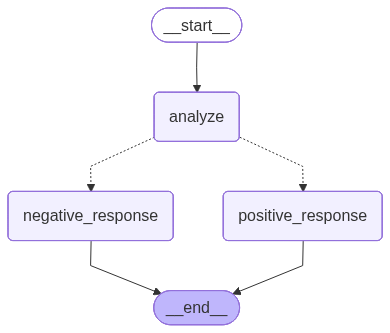

In [29]:
graph = create_router_graph()

graph

In [30]:
tweet = "Just launched my new product! the response from everyone has been amazing so far."

result = graph.invoke({'original_tweet': tweet})
result

analyzing customer tweet: Just launched my new product! the response from everyone has been amazing so far.
Sentiment Analysis is done:
sentiment='positive' confidence=0.95 reason="The text expresses excitement and satisfaction with a strong positive adjective ('amazing') and indicates a broad positive reception ('from everyone')."
current state in positive respone node: {'original_tweet': 'Just launched my new product! the response from everyone has been amazing so far.', 'sentiment': 'positive', 'confidence': 0.95}


{'original_tweet': 'Just launched my new product! the response from everyone has been amazing so far.',
 'sentiment': 'positive',
 'confidence': 0.95,
 'response_tweet': "OMG that's awesome! 🎉 Congrats on such brilliant feedback! So happy for you and your awesome community! 🔥"}

In [31]:
tweet = "Really disappointed with the service I received today."

result = graph.invoke({'original_tweet': tweet})
result

analyzing customer tweet: Really disappointed with the service I received today.
Sentiment Analysis is done:
sentiment='negative' confidence=0.1 reason="The statement expresses clear disappointment with the service, indicating a negative sentiment. The use of 'really' emphasizes the intensity of the negative feeling."
current state in negative respone node: {'original_tweet': 'Really disappointed with the service I received today.', 'sentiment': 'negative', 'confidence': 0.1}


{'original_tweet': 'Really disappointed with the service I received today.',
 'sentiment': 'negative',
 'confidence': 0.1,
 'response_tweet': "I'm so sorry to hear that! 😔 I hope things can improve soon."}